In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt



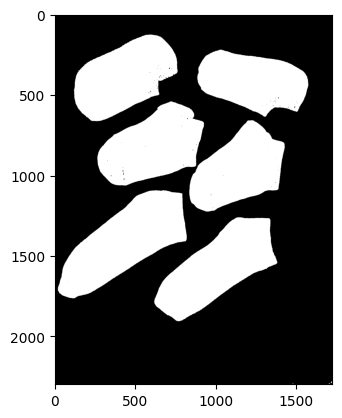

In [3]:
image_s = 'data/12.jpg'
original = cv.imread(image_s)
#original = cv.imread('data/cam/3.jpg')

gray = cv.imread(image_s, cv.IMREAD_GRAYSCALE)
#gray = cv2.cvtColor(imgage_s, cv2.COLOR_BGR2GRAY)

#Gaussian blur 
gau = cv.GaussianBlur(gray, (5, 5), 0)

#blur - division normalization
blur = cv.GaussianBlur(gray, (0,0),sigmaX=35,sigmaY=35) #, 

divide = cv.divide(gray,blur,scale=255)

th_divide = cv.threshold(gau,145, 255,cv.THRESH_BINARY)[1]
_, th1_divide = cv.threshold(gau, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

#apply moprhology
kernel = cv.getStructuringElement(cv.MORPH_RECT, (5,5))
morph = cv.morphologyEx(th_divide, cv.MORPH_CLOSE, kernel)

inverted_mask = cv.bitwise_not(morph)

roi = cv.bitwise_and(original, original, mask=inverted_mask)
plt.imshow(inverted_mask,'gray')


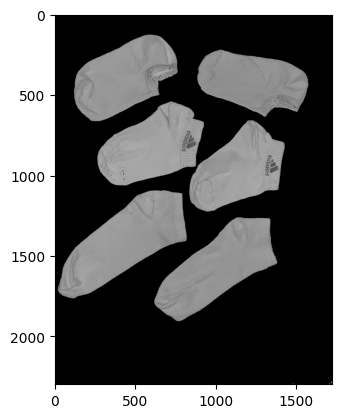

In [159]:
# Convert ROI to grayscale
roi_gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
plt.imshow(roi_gray, 'gray')

In [160]:

# Find contours 
contours, hier = cv.findContours(roi_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

socks_contour = []
for i, contour in enumerate(contours):
    if hier[0][i][2] < 0 and cv.contourArea(contour) > 600:
                socks_contour.append( contour)

len(socks_contour)

6

In [161]:

roi_gray = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)


contours, _ = cv.findContours(roi_gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

pairs = []
mathced = []

# Iterate through contours
for contour in socks_contour:
    # Calculate moments to find centroid
    M = cv.moments(contour)
    
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])

        if(cx,cy) in mathced:
            continue
        
        # Extract histogram features
        mask = np.zeros(roi_gray.shape, dtype=np.uint8)
        cv.drawContours(mask, [contour], -1, (255), thickness=cv.FILLED)
        hist = cv.calcHist([roi_gray], [0], mask, [8], [0, 256])
        
        # Normalize histogram
        hist /= hist.sum()
        
        
        for other_contour in socks_contour:
            M = cv.moments(other_contour)
            ox, oy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
            
            if ox !=cx and oy != cy:
                
                # Extract histogram features
                mask = np.zeros(roi_gray.shape, dtype=np.uint8)
                cv.drawContours(mask, [other_contour], -1, (255), thickness=cv.FILLED)
                other_hist = cv.calcHist([roi_gray], [0], mask, [8], [0, 256])
                
                # Normalize histogram
                other_hist /= other_hist.sum()
                
                shape_similarity = cv.matchShapes(contour, other_contour, cv.CONTOURS_MATCH_I1, 0)
                hist_similarity = cv.compareHist(hist, other_hist, cv.HISTCMP_CORREL)

                coo = ((cx, cy), (ox,oy))
                
                if shape_similarity < 0.4 and hist_similarity > 0.8:
                    # Save centroids of the pair
                    if((ox,oy) not in mathced):
                        pairs.append(coo)
                        mathced.append((ox,oy))
                        mathced.append((cx,cy))
                    
# Output pairs
print("Pairs found:", pairs)
print("matched:", mathced)
print(len(pairs))


Pairs found: [((1006, 1575), (430, 1415)), ((1006, 1575), (1227, 419)), ((1137, 965), (604, 822))]
matched: [(430, 1415), (1006, 1575), (1227, 419), (1006, 1575), (604, 822), (1137, 965)]
3


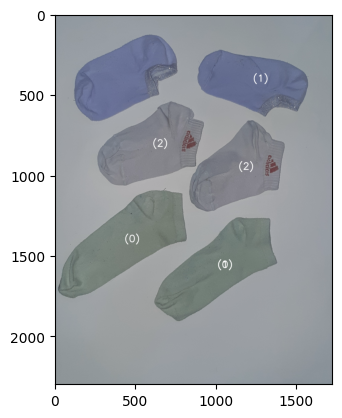

In [162]:
i=0
for pair in pairs:
    
    x, y = pair[0]  
    z, v = pair[1]
    
    cv.putText(original, f'({i})', (x,y), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv.LINE_AA)
    cv.putText(original, f'({i})', (z,v), cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3, cv.LINE_AA)
    i+=1

plt.imshow(original)